# A Case Study of TOI-3726
## Introduction
- [ExoMast Link](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html?searchQuery=%7B%22service%22%3A%22CAOMDB%22%2C%22inputText%22%3A%22TIC%20122695048%22%2C%22paramsService%22%3A%22Mast.Caom.Cone%22%2C%22title%22%3A%22MAST%3A%20TIC%20122695048%22%2C%22columns%22%3A%22*%22%2C%22caomVersion%22%3Anull%7D)
    - Filter on TESS
    - Compare with the 4th record. 
- Light curves of three TESS sectors are studied. The 1st and 3rd are both from sector 59 and the 2nd was from sector 73.
- The 2nd lc was excluded from the final curve.
- The 1st and 3rd are essentially the same data and was used to construct the final light curve.
- When the 3rd lc was flattened, a `polyorder=1` was used to remove the linear trend in the raw data.

In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightkurve import search_targetpixelfile

%matplotlib inline

/Users/sophia268238/GitHub/astronomy_ml/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# TIC 122695048 -- TOI-3726
tpf = search_targetpixelfile("TIC 122695048").download_all()

In [3]:
[t.meta['SECTOR'] for t in tpf]

[59, 73, 59]

In [4]:
tpf[2].interact(notebook_url='localhost:8889')

Text(0.5, 1.0, 'Fig 1.1 Sample Frame of Target ID: 122695048, Cadence: 1482118')

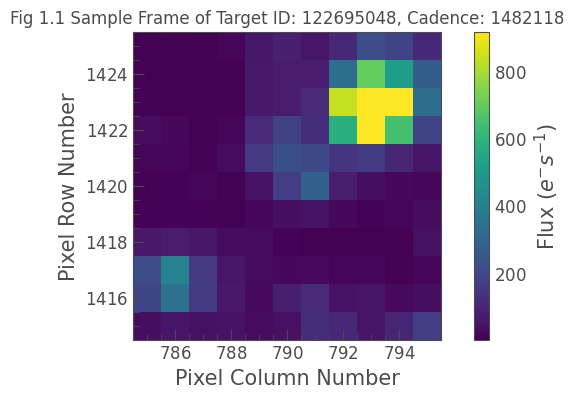

In [5]:
t0 = tpf[0]
t1 = tpf[1]
t2 = tpf[2]
t1.plot(frame=110)
plt.title("Fig 1.1 Sample Frame of Target ID: 122695048, Cadence: 1482118")

## Aperature Note
- Suprisingly, the aperture is not on the brighter region of the cut-out!
- Does it mean TOI-3726 is the dimmer of the 2 neighboring stars?

Text(0.5, 1.0, 'Fig 1.2 Sample Aperture of Target ID: 122695048, Cadence: 1211623')

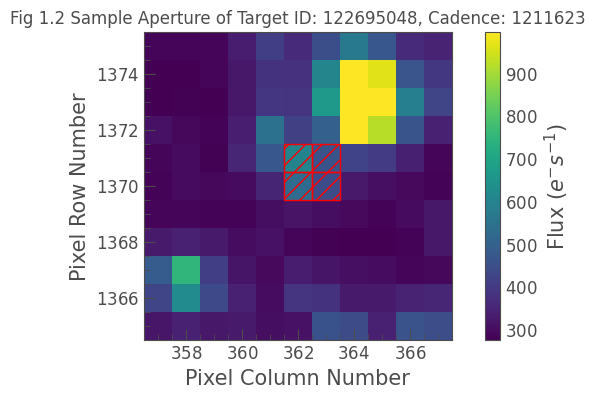

In [6]:
# Show the pipeline_mask
t0.plot(aperture_mask=t0.pipeline_mask);
plt.title("Fig 1.2 Sample Aperture of Target ID: 122695048, Cadence: 1211623")

In [7]:
lc0 = t0.to_lightcurve(aperture_mask='pipeline');
lc1 = t1.to_lightcurve(aperture_mask='pipeline');
lc2 = t2.to_lightcurve(aperture_mask='pipeline');

Text(0.5, 1.0, 'Fig 2.3 Raw Light Curve of Sector 59_1')

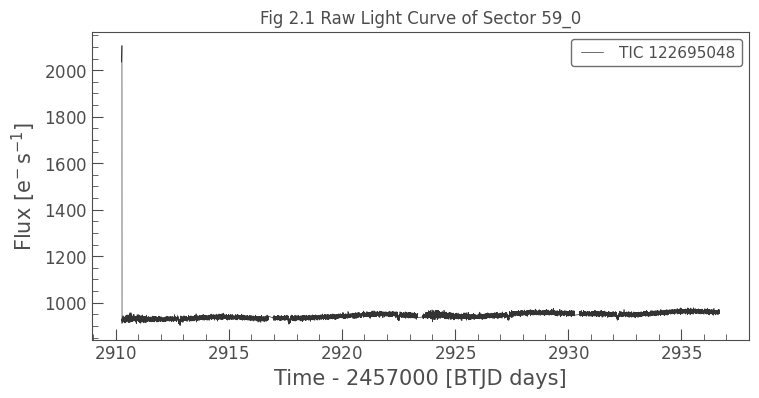

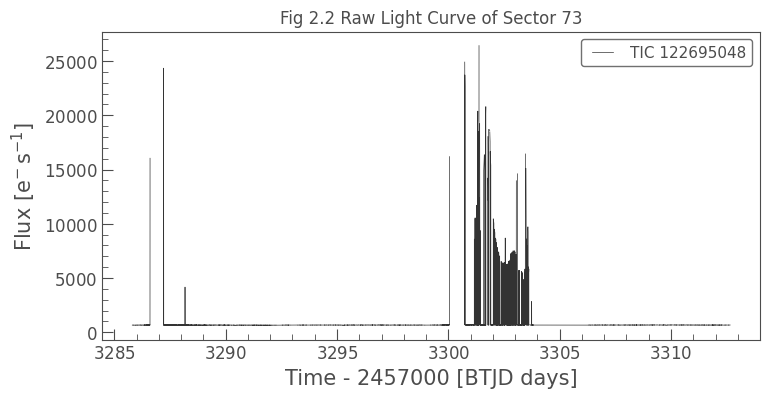

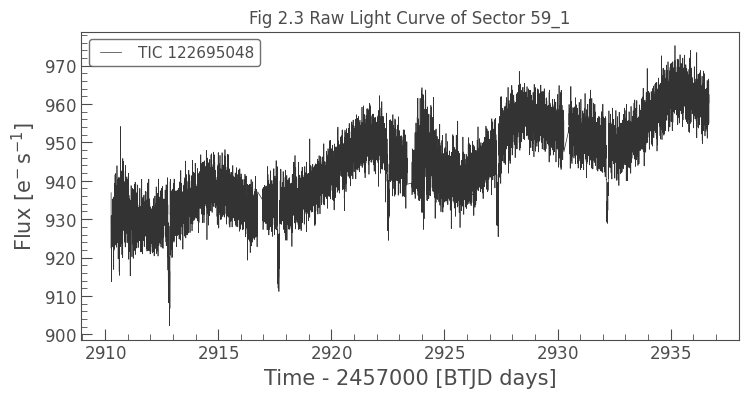

In [8]:
lc0.plot()
plt.title("Fig 2.1 Raw Light Curve of Sector 59_0")
lc1.plot()
plt.title("Fig 2.2 Raw Light Curve of Sector 73")
lc2.plot()
plt.title("Fig 2.3 Raw Light Curve of Sector 59_1")

## Picking the Light Curve
- There are 3 light curves from sector 59, 73, and 59 again.
- The 1st and 2nd lc from sector 59 are identical except the 1st is a bit longer in the beginning.
- The lc from sector 73 has significant noise. Even after the significant noise was excluded, the overall noise level was still noticibly higher than the lc from 59. It was then excluded from the final fitting.
- In the end, the 2nd lc from sector 59 was used to derive the folded lc.

Text(0.5, 1.0, 'Fig 3.2 Cleaned, Normalized, and Flattened Light Curve for Sector 73')

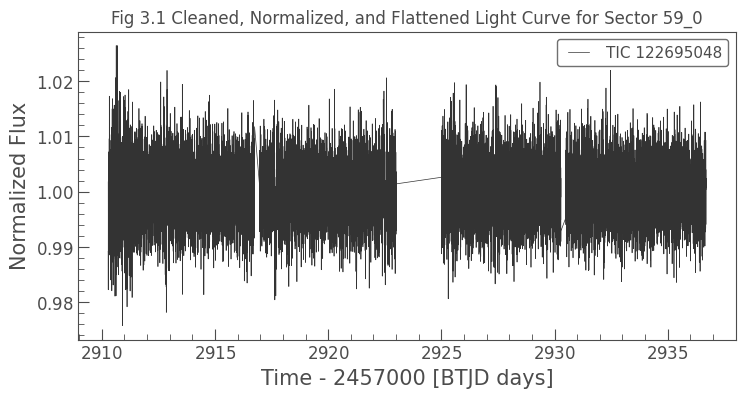

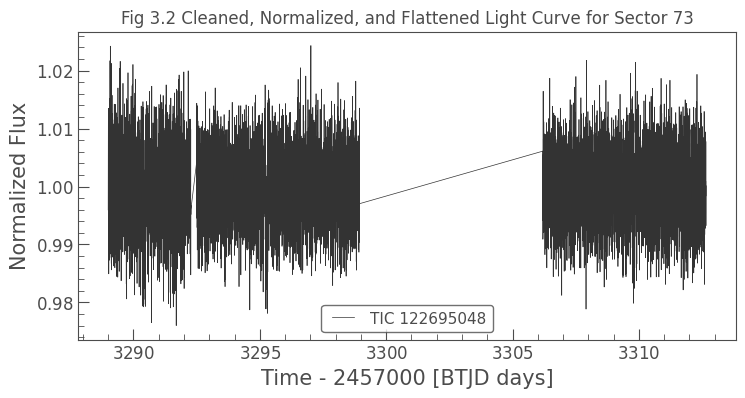

In [9]:
mask0 = ((lc0.time.value > 2900) & (lc0.time.value < 2923)) | (lc0.time.value >= 2925)
lc0_clean = lc0[mask0]
lc0_clean = lc0_clean.remove_outliers(sigma=5)
lc0_clean = lc0_clean.normalize()
lc0_clean = lc0_clean.flatten(polyorder=1)
lc0_clean.plot()
plt.title("Fig 3.1 Cleaned, Normalized, and Flattened Light Curve for Sector 59_0")

mask1 = ((lc1.time.value >= 3289) & (lc1.time.value <= 3299)) | (lc1.time.value >=3304)
lc1_clean = lc1[mask1]
lc1_clean = lc1_clean.remove_outliers(sigma=5)
lc1_clean = lc1_clean.flatten(polyorder=1)
lc1_clean = lc1_clean.normalize()
lc1_clean.plot()
plt.title("Fig 3.2 Cleaned, Normalized, and Flattened Light Curve for Sector 73")

### lc2 Preprocessing
- When flattening lc2, the default `polyorder=2` was changed to `1`. This is to remove the linear trend form the lightcurve.
- If `polyorder=2`, the transites would be optimized away to a great extent.

Text(0.5, 1.0, 'Fig 3.3 Combined Processed Light Curve for Sector 59_1')

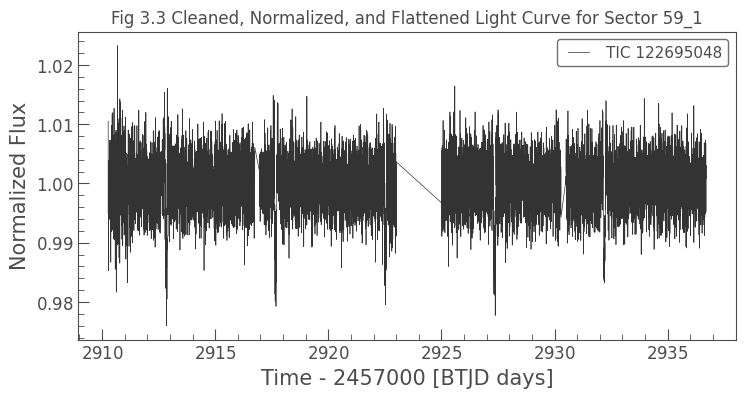

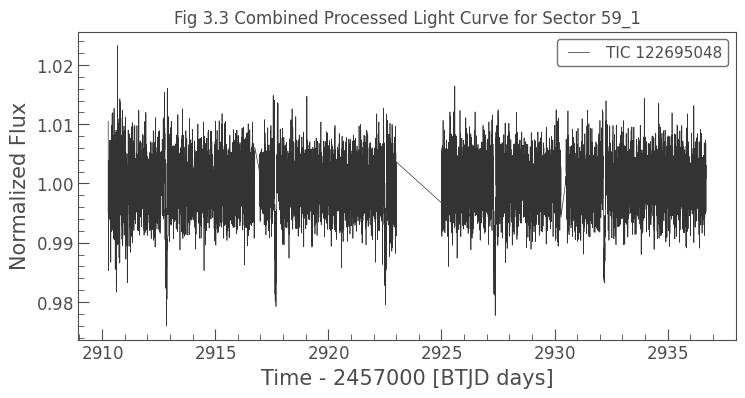

In [10]:
mask2 = ((lc2.time.value > 2900) & (lc2.time.value < 2923)) | (lc2.time.value >= 2925)
lc2_clean = lc2[mask2]
# lc2_clean = lc2_clean.remove_outliers(sigma=5)
lc2_clean = lc2_clean.flatten(polyorder=1)
lc2_clean = lc2_clean.normalize()
lc2_clean.plot()
plt.title("Fig 3.3 Cleaned, Normalized, and Flattened Light Curve for Sector 59_1")

lc_combined_clean = lc2_clean
lc_combined_clean = lc_combined_clean
lc_combined_clean.plot()
plt.title("Fig 3.3 Combined Processed Light Curve for Sector 59_1")

/Users/sophia268238/GitHub/astronomy_ml/.venv/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0.5, 1.0, 'Fig 4.1 Periodogram of the Combined Light Curve')

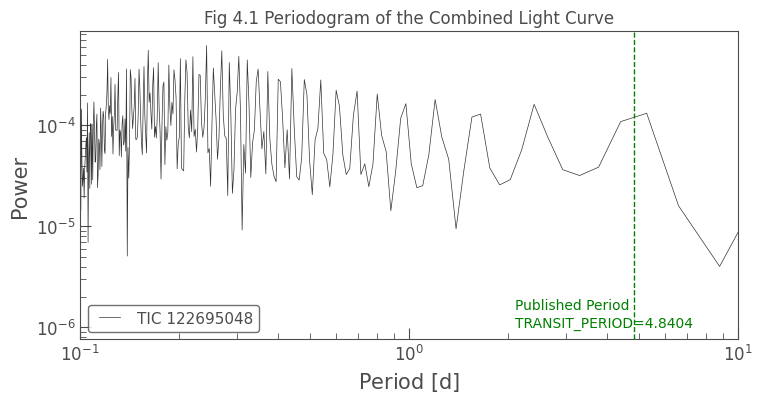

In [11]:
# Published transit period
TRANSIT_PERIOD = 4.8404430882223

pg = lc_combined_clean.to_periodogram(oversample_factor=1)
pg.plot(view='period', scale='log')
plt.xlim(0.1, 10)
plt.axvline(x=TRANSIT_PERIOD, color='g', linestyle='--', linewidth=1)
plt.text(x=2.1, y=15e-7, s='Published Period', fontsize=10, color='g')
plt.text(x=2.1, y=10e-7, s=f'TRANSIT_PERIOD={TRANSIT_PERIOD:.4f}', fontsize=10, color='g')
plt.title("Fig 4.1 Periodogram of the Combined Light Curve")

Text(0.5, 1.0, 'Fig 5.1 Folded Light Curve with Published Period (4.8404430882223 Days)')

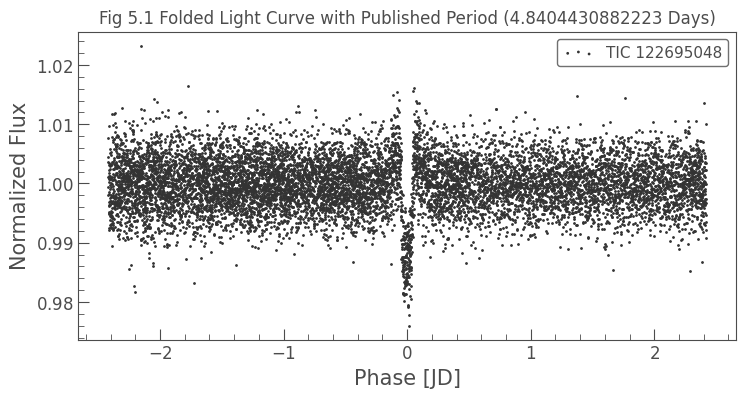

In [12]:
# Plot the folded curve.
folded_lc = lc_combined_clean.fold(period=TRANSIT_PERIOD, epoch_phase=2916.22)
folded_lc.scatter();
plt.title(f"Fig 5.1 Folded Light Curve with Published Period ({TRANSIT_PERIOD} Days)")

Text(0.5, 1.0, 'Fig 5.2 Zoomed in Folded Light Curve with Published Period (4.8404430882223 Days)')

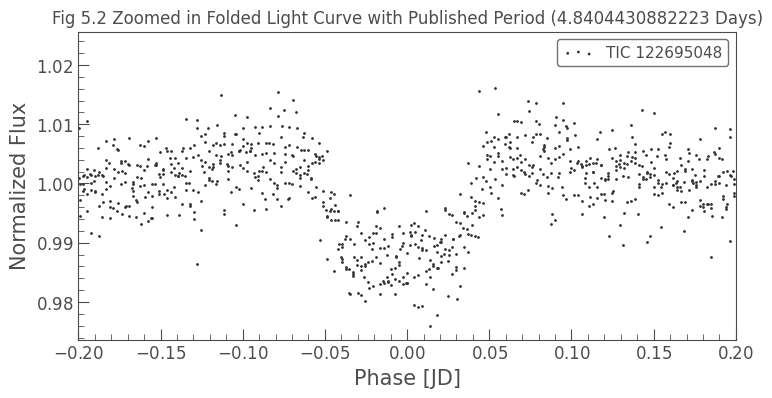

In [13]:
folded_lc.scatter();
plt.xlim(-0.2, 0.2)
plt.title(f"Fig 5.2 Zoomed in Folded Light Curve with Published Period ({TRANSIT_PERIOD} Days)")

Text(-2, 0.995, 'Average Binning Ratio: 21.3988')

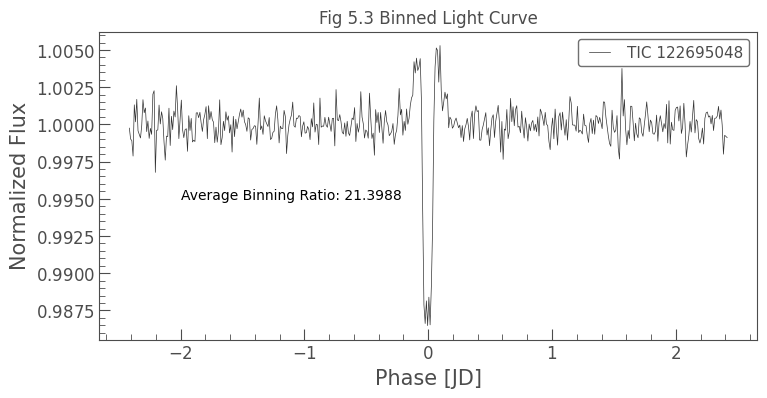

In [14]:
binned_lc = folded_lc.bin(time_bin_size=0.01)
binned_lc.plot()
plt.title("Fig 5.3 Binned Light Curve")
binning_avg_size = len(lc_combined_clean) / len(binned_lc)
plt.text(-2, 0.995, f"Average Binning Ratio: {binning_avg_size:.4f}")

Text(0.5, 1.0, 'Fig 5.4 Zoomed in Binned Light Curve')

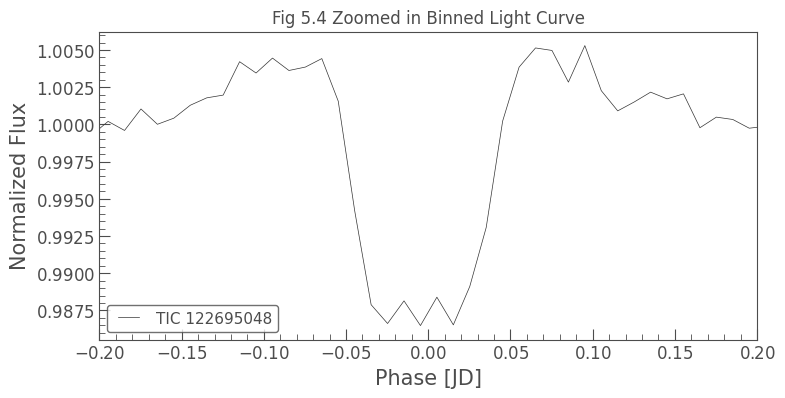

In [15]:
binned_lc = folded_lc.bin(time_bin_size=0.01)
binned_lc.plot()
plt.xlim(-0.2, 0.2)
plt.title("Fig 5.4 Zoomed in Binned Light Curve")